In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [2_1  Allow a flexible input shape in the custom layer](#coding_reading21)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation = 'relu')
        self.dense_2 = Dense(10)
    
    def call(self, inputs):
        x = self.dense_1(inputs)
        return self.dense_2(x)

In [4]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation = 'relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)
        
    def call(self, inputs, training = True):
        x = self.dense_1(inputs)
        if training:
            x = self.dropout(x)
        return self.dense_2(x)

In [5]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation = 'relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        
    def call(self, inputs, training = True):
        x = self.dense_1(inputs)
        return self.dense_2(x)

In [6]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  650       
                                                                 
 dense_2 (Dense)             multiple                  0 (unused)
                                                                 
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [36]:
# Create a custom layer

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                                initializer = 'random_normal')
        self.b = self.add_weight(shape = (units,),
                                initializer = 'zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[-0.02341494  0.04701363 -0.19028988]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03389566, -0.0535886 , -0.03706326],
       [ 0.03250873,  0.01176784, -0.00132158],
       [ 0.03396152,  0.03414179, -0.02033684],
       [-0.1324061 , -0.03666922, -0.0326592 ],
       [ 0.00862525,  0.09136182, -0.09890901]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [37]:
# Specify trainable weights

dense_layer = MyLayer(3, 5)

In [38]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 2
non-trainable weights: 0


In [39]:
# Change "trainable" feature from True to False
class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                                initializer = 'random_normal',
                                trainable = False)
        self.b = self.add_weight(shape = (units,),
                                initializer = 'zeros',
                                trainable = False)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [40]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [41]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                                initializer = 'random_normal')
        self.b = self.add_weight(shape = (units,),
                                initializer = 'zeros')
        self.sum_activation = tf.Variable(initial_value = tf.zeros((units,)),
                                          trainable = False)
        self.number_call = tf.Variable(initial_value = 0, trainable = False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis = 0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3, 5)

In [42]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.09377643  0.04652394 -0.06608257]


In [43]:
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.09377643  0.04652394 -0.06608257]
[ 0.09377643  0.04652394 -0.06608257]


In [44]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

#### Implement the custom layers into a model

In [45]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [46]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01628469 0.01130896 0.02333818 0.01103962 0.02324288 0.03268867
  0.01615622 0.00764996 0.02279223 0.02407543 0.01920155 0.00472215
  0.01521532 0.02610866 0.01145107 0.01420976 0.00881724 0.00549507
  0.01071452 0.00461591 0.00552178 0.05063766 0.01170105 0.04163625
  0.05053527 0.00495784 0.04923613 0.01405129 0.01196756 0.11123493
  0.00258483 0.04010612 0.00539239 0.0326574  0.01745203 0.0083904
  0.09066956 0.01535972 0.01462785 0.01245255 0.00308008 0.00540245
  0.05764113 0.00267141 0.00647573 0.02442855]], shape=(1, 46), dtype=float32)
Model: "my_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_45 (MyLayer)       multiple                  640064    
                                                                 
 my_dropout_24 (MyDropout)   multiple                  0         
                                                                 
 my_layer_46 (MyLa

***
<a id="coding_reading21"></a>
## Allow a flexible input shape in the custom layer

You can delay the weight creation by using the `build` method to define the weights. The `build` method is executed when the `__call__` method is called, meaning the weights are only created only the layer is called with a specific input.

The `build` method has a required argument `input_shape`, which can be used to define the shapes of the layer weights.

### Resource:
https://www.tensorflow.org/guide/keras/custom_layers_and_models#best_practice_deferring_weight_creation_until_the_shape_of_the_inputs_is_known

In [47]:
# Rewrite the custom layer with lazy weight creation

class MyLayer(Layer):

    def __init__(self, units, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros')
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

Now, when you instantiate the layer, you only need to specify the number of units in the dense layer (`units`), and not the input size (`input_dim`).

### Create a custom layer with flexible input size

In [48]:
#  Create a custom layer with 3 units

dense_layer = MyLayer(3) 

This layer can now be called on an input of any size, at which point the layer weights will be created and the input size will be fixed.

In [49]:
# Call the custom layer on a Tensor input of ones of size 5

x = tf.ones((1,5))
print(dense_layer(x))

tf.Tensor([[ 0.02250491 -0.09947845 -0.01189659]], shape=(1, 3), dtype=float32)


In [50]:
# Print the layer weights

dense_layer.weights

[<tf.Variable 'my_layer_48/Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[ 0.00680099, -0.01997885,  0.00041741],
        [-0.01180061, -0.03206279, -0.07344203],
        [-0.00653773, -0.00165346,  0.0430146 ],
        [ 0.01119763, -0.04057274, -0.01186073],
        [ 0.02284463, -0.00521061,  0.02997416]], dtype=float32)>,
 <tf.Variable 'my_layer_48/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

### Create a new custom layer and pass in a different sized input

In [51]:
#  Create a new custom layer with 3 units

dense_layer = MyLayer(3) 

In [52]:
# Call the custom layer on a Tensor input of ones of size 4

x = tf.ones((1,4))
print(dense_layer(x))

tf.Tensor([[ 0.08577169 -0.01199797  0.00438497]], shape=(1, 3), dtype=float32)


In [53]:
# Print the layer weights

dense_layer.weights

[<tf.Variable 'my_layer_49/Variable:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.06299651, -0.03748653, -0.02326453],
        [ 0.04857215,  0.01676789, -0.03914747],
        [-0.01995296, -0.02789515,  0.01204786],
        [-0.005844  ,  0.03661582,  0.05474911]], dtype=float32)>,
 <tf.Variable 'my_layer_49/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

Note that the code for creating a custom layer object is identical, but the shape of the weights in the layer depend on the size of the input passed to the layer.

### Flexible input shapes in models

Deferring the weight creation until the layer is called is also useful when using the custom layer as an intermediate layer inside a larger model. In this case you may want to create several custom layer objects in the model, and it is tedious to keep track of the input shape that each of the custom layers needs. 

By deferring the weight creation as above, the input shape can be inferred from the output of the previous layer.

In [54]:
# Create a model using the custom layer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Softmax

class MyModel(Model):

    def __init__(self, units_1, units_2, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.layer_1 = MyLayer(units_1)
        self.layer_2 = MyLayer(units_2)

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.layer_2(x)
        return Softmax()(x)

In the above model definition, the custom layer `MyLayer` is used twice. Notice that each instance of the custom layer object can have a different input size, depending on the arguments used to create the model and the inputs passed into the model

In [55]:
# Create a custom model object

model = MyModel(units_1=32, units_2=10)

We can create and initialise all of the weights of the model by passing in an example `Tensor input`.

In [57]:
# Create and initialize all of the model weights

_ = model(tf.ones((1, 100)))

# Print the model summary

model.summary()

Model: "my_model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_50 (MyLayer)       multiple                  3232      
                                                                 
 my_layer_51 (MyLayer)       multiple                  330       
                                                                 
Total params: 3,562
Trainable params: 3,562
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [58]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

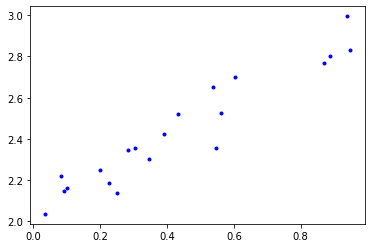

In [59]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [60]:
from tensorflow.keras.layers import Layer

In [64]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape = (1,),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape = (1, ),
                             initializer = 'zeros')
    
  def call(self, inputs):
    return (self.m * inputs + self.b)

linear_regression = LinearLayer()

print('\nPredictions:\n', linear_regression(x_train))
print('\nWeights of the linear regression layer:\n', linear_regression.weights)


Predictions:
 tf.Tensor(
[0.00196035 0.01154011 0.01984482 0.00824404 0.00479754 0.00214695
 0.0113509  0.00075715 0.00529692 0.00643635 0.0017585  0.01842844
 0.00596907 0.01879559 0.02005121 0.00422918 0.0091597  0.0073083
 0.01190224 0.01274383], shape=(20,), dtype=float32)

Weights of the linear regression layer:
 [<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.02117423], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [65]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 5.9597383


#### Train and plot the model

In [69]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 5e-2
steps = 25

for i in range(steps):

  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  ## Update m
  linear_regression.m.assign_sub(learning_rate * gradients[0])
  ## Update b 
  linear_regression.b.assign_sub(learning_rate * gradients[1])

  ## Check progress in each step
  print('Step %d - Loss: %f\n' % (i+1, loss.numpy()))

Step 1 - Loss: 0.006754

Step 2 - Loss: 0.006752

Step 3 - Loss: 0.006750

Step 4 - Loss: 0.006748

Step 5 - Loss: 0.006745

Step 6 - Loss: 0.006743

Step 7 - Loss: 0.006741

Step 8 - Loss: 0.006739

Step 9 - Loss: 0.006737

Step 10 - Loss: 0.006735

Step 11 - Loss: 0.006733

Step 12 - Loss: 0.006731

Step 13 - Loss: 0.006729

Step 14 - Loss: 0.006727

Step 15 - Loss: 0.006725

Step 16 - Loss: 0.006723

Step 17 - Loss: 0.006721

Step 18 - Loss: 0.006719

Step 19 - Loss: 0.006717

Step 20 - Loss: 0.006716

Step 21 - Loss: 0.006714

Step 22 - Loss: 0.006712

Step 23 - Loss: 0.006710

Step 24 - Loss: 0.006709

Step 25 - Loss: 0.006707



m:1,  trained m:[0.92050886]
b:2,  trained b:[2.0379093]



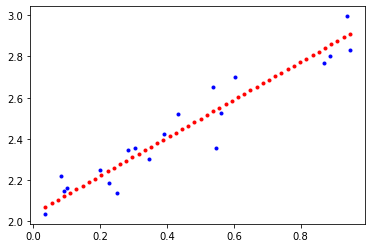

In [71]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}\n".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [76]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape = (input_shape[-1], self.units),
                                initializer = 'random_normal',
                                name = 'kernel')
        self.b = self.add_weight(shape = (self.units,),
                                initializer = 'zeros',
                                 name = 'bias')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)      

In [77]:
model = MyModel(64,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02317688 0.00719133 0.04732593 0.07542625 0.0133733  0.01702228
  0.01967919 0.02402653 0.01520357 0.03522412 0.03925518 0.04173747
  0.00743763 0.02227984 0.01619222 0.01272904 0.02762311 0.04078956
  0.01654528 0.01439777 0.02336574 0.02211007 0.01389055 0.02926169
  0.01818145 0.01492505 0.00682979 0.02416052 0.02547047 0.00786574
  0.00827448 0.00961983 0.03627542 0.03180626 0.01003351 0.02756411
  0.00711655 0.01148482 0.01405016 0.00788242 0.03690767 0.01252545
  0.01256799 0.01380891 0.03835403 0.01903078]], shape=(1, 46), dtype=float32)
Model: "my_model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_52 (MyLayer)       multiple                  640064    
                                                                 
 my_dropout_26 (MyDropout)   multiple                  0         
                                                                 
 my_layer_53 (MyL

#### Load the reuters dataset and define the class_names 

In [74]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2121728/2110848 [==============================] - 0s 0us/step


In [78]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [79]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

565248/550378 [==============================] - 0s 0us/step


In [80]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [81]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [82]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [83]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [89]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

### Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 5e-3

for epoch in range(num_epochs):

  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  ### TRAINING LOOP
  for x, y in train_dataset:

    ## Optimize model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    ## Compute current loss
    epoch_loss_avg(loss_value)

    ## Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

  ## End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d} - Loss: {:.3f} - Accuracy: {:.3%}".format(epoch + 1, epoch_loss_avg.result(), epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 001 - Loss: 1.678 - Accuracy: 71.020%
Epoch 002 - Loss: 1.694 - Accuracy: 71.510%
Epoch 003 - Loss: 1.685 - Accuracy: 71.176%
Epoch 004 - Loss: 1.683 - Accuracy: 71.710%
Epoch 005 - Loss: 1.680 - Accuracy: 71.766%
Epoch 006 - Loss: 1.676 - Accuracy: 71.654%
Epoch 007 - Loss: 1.674 - Accuracy: 71.666%
Epoch 008 - Loss: 1.661 - Accuracy: 71.576%
Epoch 009 - Loss: 1.664 - Accuracy: 71.677%
Epoch 010 - Loss: 1.668 - Accuracy: 72.077%
Duration :97.320


#### Evaluate the model

In [90]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [91]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [92]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.807
Test accuracy: 68.121%


#### Plot the learning curves

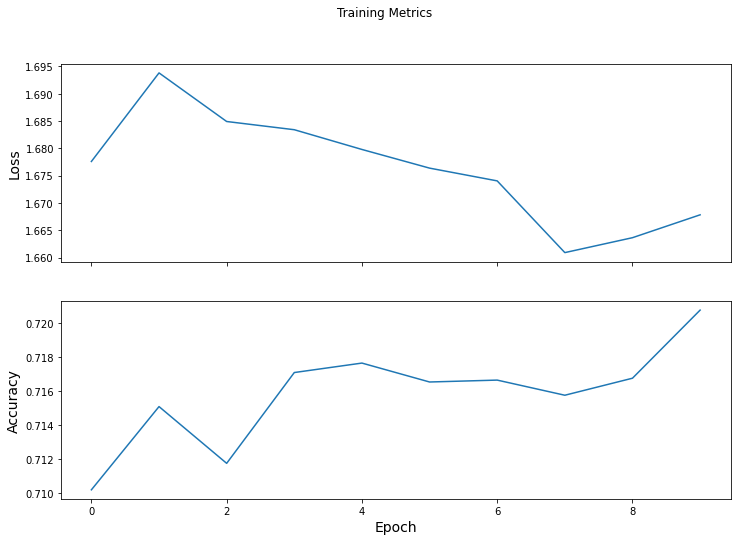

In [93]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [94]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [96]:
# Initialize a new model

model = MyModel(64,64,46)

***USING REUTERS DATASET, DATA PREPROCESSING & OPTIMIZER-LOSS FUNCTIONS IN PREVIOUS SECTION***

#### Redefine the grad function using the @tf.function decorator

In [97]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [98]:
# Re-run the training loop

# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

### Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 5e-3

for epoch in range(num_epochs):

  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  ### TRAINING LOOP
  for x, y in train_dataset:

    ## Optimize model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    ## Compute current loss
    epoch_loss_avg(loss_value)

    ## Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

  ## End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d} - Loss: {:.3f} - Accuracy: {:.3%}".format(epoch + 1, epoch_loss_avg.result(), epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 001 - Loss: 2.433 - Accuracy: 56.123%
Epoch 002 - Loss: 1.939 - Accuracy: 64.128%
Epoch 003 - Loss: 1.850 - Accuracy: 67.023%
Epoch 004 - Loss: 1.799 - Accuracy: 68.047%
Epoch 005 - Loss: 1.769 - Accuracy: 68.604%
Epoch 006 - Loss: 1.749 - Accuracy: 69.016%
Epoch 007 - Loss: 1.737 - Accuracy: 69.216%
Epoch 008 - Loss: 1.718 - Accuracy: 69.316%
Epoch 009 - Loss: 1.699 - Accuracy: 69.628%
Epoch 010 - Loss: 1.697 - Accuracy: 69.572%
Duration :96.292


#### Print the autograph code

In [99]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

